In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV

dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression()
knn = KNeighborsClassifier()

#train_X.drop[(['T_MR'], axis=1, inplace=True)
#train['Fare'].fillna(train.groupby('Pclass')['Fare'].transform('median'))

### 1. 데이터 사전 탐색 (EDA)

In [2]:
data = pd.read_csv('diabetes.csv')
data.shape
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
### 무조건 점수부터 보자 (결측없고 수치형피쳐)

In [4]:
def myfit(X, y, model, imp=1, tsize=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize, random_state=100, shuffle=False)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    accuracy = accuracy_score(pred, y_test)
    precision = precision_score(pred, y_test)
    recall = recall_score(pred, y_test)
    f1 = f1_score(pred, y_test)
    print('Accuracy:{:.6f} Precision:{:.6f} Recall:{:.6f} F1:{:.6f}'.format(accuracy, precision, recall, f1))
    
#     if imp==1:
#         imp_df = pd.DataFrame({'feature': X_train.columns, 'importance':model.feature_importances_})
#         imp_df = imp_df.sort_values('importance', ascending=False).T
#         print(imp_df)

In [5]:
#불균형 확인

In [6]:
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

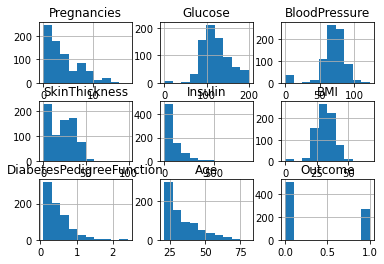

In [7]:
data.hist()
plt.show()

In [8]:
# 0데이터 확인

In [9]:
nan_dict = {'CNT':data.isin([0]).sum(), 'RATE': data.isin([0]).sum()/data.shape[0] * 100}
nan_df = pd.DataFrame(nan_dict)
nan_df[nan_df['RATE']>0].sort_values('CNT', ascending=False)

,CNT,RATE
Outcome,500,65.104167
Insulin,374,48.697917
SkinThickness,227,29.557292
Pregnancies,111,14.453125
BloodPressure,35,4.557292
BMI,11,1.432292
Glucose,5,0.651042


In [10]:
# 각 피쳐당 0값을 평균으로 대체

In [11]:
zero_feature = ['Insulin', 'SkinThickness', 'BloodPressure', 'BMI']
zero_mean = data[zero_feature].mean()
data[zero_feature] = data[zero_feature].replace(0, zero_mean)

rf = RandomForestClassifier(random_state=100)
df_y = data["Outcome"]
df_X = data.drop("Outcome", axis=1)
print(df_y.shape, df_X.shape)


(768,) (768, 8)


In [29]:
def myscore(y_test, pred, proba, pr_curve=0, auc_curve=0):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, proba[:,-1])
    #print(f'{scaler[0]:s}:{df_score:.4f}')
    #print('Accuracy:{:.6f} Precision:{:.6f} Recall:{:.6f} F1:{:.6f}'.format(accuracy, precision, recall, f1))
    print(f'Accuracy:{accuracy:.6f}, Precision:{precision:.6f}, Recall:{recall:.6f}, F1:{f1:.6f}, AUC:{auc:.6f}')
    
    mtx = confusion_matrix(y_test, pred)
    print(mtx)
    
    if pr_curve==1:
        mycurve(y_test, proba)
    if auc_curve==1:
        mycurve_auc(y_test, proba)

In [13]:
from sklearn.metrics import precision_recall_curve
def mycurve(y_test, proba):
    precision, recall, thresholds = precision_recall_curve(y_test, proba[:, -1])
    print(len(precision), len(recall), len(thresholds))
    plt.plot(thresholds, precision[:len(thresholds)], label='precision')
    plt.plot(thresholds, recall[:len(thresholds)], label='recall')
    plt.xlabel('thresholds')
    plt.ylabel('score')
    plt.grid()
    plt.legend()
    plt.show()

In [14]:
# AUC일정한 이유를 찾아서
def mycurve_auc(y_test, proba):
    fpr, tpr, thresholds = roc_curve(y_test, proba[:,-1])
    print(len(fpr), len(tpr), len(thresholds))
    plt.plot(fpr, tpr, label='roc')
    plt.plot([0,1], [0,1], label='th:0.5')
    plt.xlabel('FPR(1-TNR(specificity))')       #FP
    plt.ylabel('TPR(recall, sensitivity)')      #TP
    plt.title(f'auc:{roc_auc_score(y_test, proba[:,-1]):.4f}') #roc 아래 면적 = auc
    plt.grid()
    plt.legend()
    plt.show()

In [15]:
# 정규화, 이상치, 스케일링

## 방법1 각각 스케일링

In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
std_scalar = StandardScaler()
rbs_scaler = RobustScaler()
mmx_scaler = MinMaxScaler()
scaler_list = [('StandardScaler',std_scalar)]#, ('RobustScaler',rbs_scaler), ('MinMaxScaler',mmx_scaler)]

for scaler in scaler_list:
    #df_X_scaler = scaler[1].fit_transform(df_X)
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=100, shuffle=False)
    X_train_scaler = scaler[1].fit_transform(X_train)   # 각각 스케일링
    X_test_scaler  = scaler[1].transform(X_test)

    rf.fit(X_train_scaler, y_train)
    pred = rf.predict(X_test_scaler) #테스트(본시험) 파일 (스케일링 안한 상태)
    myscore(y_test, pred)

# std_scaler.fit(test_X) # 스케일변환 금지 -> 테스트셋에는 fit 적용 금지
# std_scaler.transform(test_X)

TypeError: myscore() missing 1 required positional argument: 'proba'

### 방법2 전체 스케일링후 나누기 (시계열은 위험)

In [ ]:
for scaler in scaler_list:
    df_X_scaler = scaler[1].fit_transform(df_X)  # 스케일링하고 나누기
    X_train, X_test, y_train, y_test = train_test_split(df_X_scaler, df_y, test_size=0.2, random_state=100, shuffle=False)

    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    myscore(y_test, pred)

### Proba

[1 0 0 0 1] [[0.19 0.81]
 [0.92 0.08]
 [0.66 0.34]
 [0.92 0.08]
 [0.42 0.58]]
Accuracy:0.733766, Precision:0.659091, Recall:0.527273, F1:0.585859, AUC:0.830211
[[84 15]
 [26 29]]
61 61 60


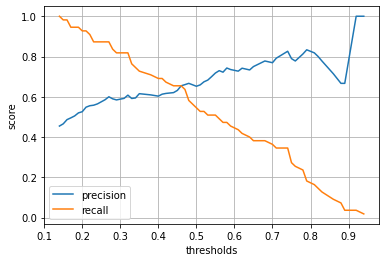

62 62 62


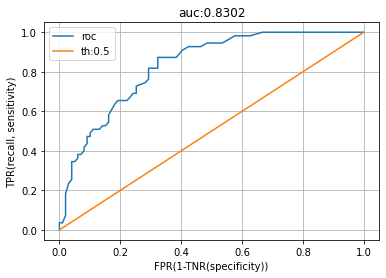

In [26]:
std_scalar = StandardScaler()
    
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=100, shuffle=False)

X_train_scaler = std_scalar.fit_transform(X_train)
X_test_scaler  = std_scalar.transform(X_test)

rf.fit(X_train_scaler, y_train)
pred = rf.predict(X_test_scaler)
proba = rf.predict_proba(X_test_scaler)

print(pred[:5], proba[:5])

myscore(y_test, pred, proba, pr_curve=1, auc_curve=1)

In [ ]:
# FPR=0 인 경우 -> FP=0 -> th=1 = all Negative
# FPR=1 인 경우 -> FP=1 -> th=0 = all Positive

In [31]:
from sklearn.preprocessing import Binarizer
ths = [0, 0.35, 0.4, 0.45, 0.5, 0.55, 1] # 임계치 임의조정
for th in ths:
    bi = Binarizer(threshold=th)
    pred = bi.fit_transform(proba[:,-1].reshape(-1,1))
    print(f'N:P {th, 1-th}')
    myscore(y_test, pred, proba)

N:P (0, 1)
Accuracy:0.363636, Precision:0.359477, Recall:1.000000, F1:0.528846, AUC:0.830211
[[ 1 98]
 [ 0 55]]
N:P (0.35, 0.65)
Accuracy:0.733766, Precision:0.609375, Recall:0.709091, F1:0.655462, AUC:0.830211
[[74 25]
 [16 39]]
N:P (0.4, 0.6)
Accuracy:0.733766, Precision:0.612903, Recall:0.690909, F1:0.649573, AUC:0.830211
[[75 24]
 [17 38]]
N:P (0.45, 0.55)
Accuracy:0.753247, Precision:0.654545, Recall:0.654545, F1:0.654545, AUC:0.830211
[[80 19]
 [19 36]]
N:P (0.5, 0.5)
Accuracy:0.733766, Precision:0.659091, Recall:0.527273, F1:0.585859, AUC:0.830211
[[84 15]
 [26 29]]
N:P (0.55, 0.44999999999999996)
Accuracy:0.753247, Precision:0.729730, Recall:0.490909, F1:0.586957, AUC:0.830211
[[89 10]
 [28 27]]
N:P (1, 0)
Accuracy:0.642857, Precision:0.000000, Recall:0.000000, F1:0.000000, AUC:0.830211
[[99  0]
 [55  0]]
